# Dask Delayed

In many situations you may want to directly run an algorithm on a distributed cluster rather than using a high-level library like Dask data collections. When you find yourself wanted to parallelize a particular algorithm or set of code, Dask Delayed can be a powerful tool.

When using Dask Delayed you do not need to directly make any changes to your existing code. Instead, you'll take your existing functions and use those as the blocks that get run in parallel on the cluster. Dask will take the functions, built a task graph to determine how they should be run, then execute them in parallel.

In the example below we have a formula one laptime dataset taken from [kaggle](https://www.kaggle.com/rohanrao/formula-1-world-championship-1950-2020?select=lap_times.csv). We will be finding range of lap time for a formula one driver. First we create a pandas DataFrame out of csv file and filter out data for driver ID 20. We then create and run three functions: finding maximum laptime, finding minimum laptime, and then getting the range out of it. We'll start with it entirely using pandas and without Dask.  

In [1]:
import pandas as pd

f1 = pd.read_csv("s3://saturn-public-data/examples/Dask/f1_laptime.csv",storage_options={"anon": True})
d_20 = f1[f1['driverId']==20]

def max_lap(x):    
    return max(x)

def min_lap(x):
    return min(x)

def range_lap(a, b):
    return a - b

We call all three functions one by one. Each function gets executed in that sequence and in the end we print the result.  

In [2]:
a = max_lap(d_20.milliseconds)
b = min_lap(d_20.milliseconds)
c = range_lap(a,b)

c

7448247

To use Dask, first start the Dask cluster associated with the Saturn Cloud resource:

In [ ]:
from dask_saturn import SaturnCluster
from dask.distributed import Client

n_workers = 3
cluster = SaturnCluster(n_workers=n_workers)
client = Client(cluster)
client.wait_for_workers(n_workers)

Now let us use `dask.delayed` around each function. As an alternate you can also use `@dask.delayed`. This will manually establish that the function should be lazy, and not evaluate until you tell it. So all this while instead of computing each function one by one, Dask Delayed will be creating a task graph which will indicate how to achieve parallelism. Note when we print result `c` this time, it does not print the result, instead it prints object.  

In [3]:
import dask

max_lap = dask.delayed(max_lap)
min_lap = dask.delayed(min_lap)
range_lap = dask.delayed(range_lap)

a = max_lap(d_20.milliseconds)
b = min_lap(d_20.milliseconds)
c = range_lap(a,b)

c

Delayed('range_lap-0dfde475-3f85-4ed4-b28c-09df9f9fa572')

We can visualize what the task graph for the Dask operation is by using the `.visualize()` command:

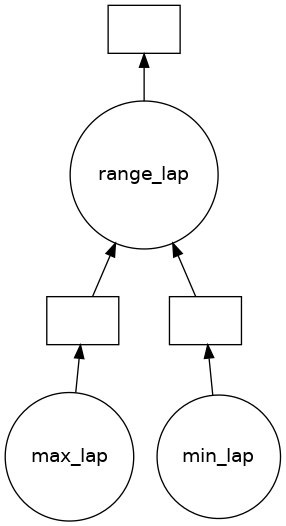

In [4]:
c.visualize()

Only when you do `.compute()` , dask delayed will perform execution in sequence shown in task graph. 

In [5]:
c.compute()

7448247